In [1]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
import dotenv
from langchain_openai import OpenAIEmbeddings

dotenv.load_dotenv()
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

pc =Pinecone()

index_name = "tax-index-langgraph"

index = pc.Index(index_name)
vectorstore = PineconeVectorStore(embedding=embedding, index=index)


retriever = vectorstore.as_retriever(search_kwargs={'k':3})

C:\Users\soobi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    
    query = state['query']
    docs = retriever.invoke(query)
    print(f'docs = {docs}')
    return {'context': docs}

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [5]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다


def generate(state: AgentState) -> AgentState:
    
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state['context']
    query = state['query']
    
    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = generate_prompt | llm
    
    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 반환합니다
    return {'answer': response}

In [6]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client
from typing import Literal

client = Client()
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
   
    query = state['query']
    context = state['context']
    context_text = "\n\n".join([doc.page_content for doc in context])
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context_text})

    print(f'response: {response['Score']}')
    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'
    
    return 'irrelevant'

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
   
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}


In [8]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    return response

In [9]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client

client = Client()
helpfulness_prompt = client.pull_prompt("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> str:
   
    # state에서 질문과 답변을 추출합니다
    query = state['query']
    answer = state['answer']

    # 답변의 유용성을 평가하기 위한 체인을 생성합니다
    helpfulness_chain = helpfulness_prompt | llm
    
    # 질문과 답변으로 체인을 호출합니다
    response = helpfulness_chain.invoke({'student_answer': answer, 'question': query})

    # 점수가 1이면 'helpful'을 반환하고, 그렇지 않으면 'unhelpful'을 반환합니다
    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState:
   
    # 이 함수는 현재 아무 작업도 수행하지 않으며 state를 그대로 반환합니다
    return state

In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance, 
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [12]:
graph = graph_builder.compile()

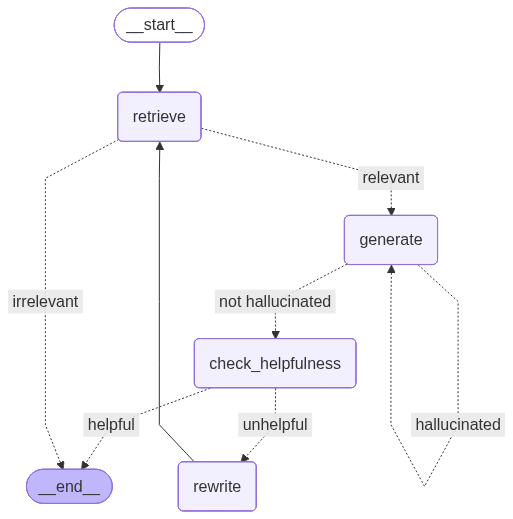

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원인 거주자의 납부해야하는 소득세 알려줘'}
graph.invoke(initial_state)

docs = [Document(id='a6c9015f-092f-4aa3-819b-e23588bb0a0f', metadata={'source': './tax_combined_final.txt'}, page_content='소득세법\n하는 자(제119조제9호에 따른 국내원천 부동산등양도소득을 지급하는 거주자 및 비거주자는 제외한다)는 제127조\n에도 불구하고 그 소득을 지급할 때에 다음 각 호의 금액을 그 비거주자의 국내원천소득에 대한 소득세로서 원천징\n수하여 그 원천징수한 날이 속하는 달의 다음 달 10일까지 대통령령으로 정하는 바에 따라 원천징수 관할 세무서,\n한국은행 또는 체신관서에 납부하여야 한다. <개정 2013. 1. 1., 2016. 12. 20., 2018. 12. 31., 2019. 12. 31., 2020. 12.\n29.>\n1. 제119조제1호에 따른 국내원천 이자소득: 다음 각 목의 구분에 따른 금액\n가. 국가·지방자치단체 및 내국법인이 발행하는 채권에서 발생하는 이자소득: 지급금액의 100분의 14\n나. 가목 외의 이자소득: 지급금액의 100분의 20\n2. 제119조제2호에 따른 국내원천 배당소득: 지급금액의 100분의 20\n3. 제119조제4호에 따른 국내원천 선박등임대소득 및 같은 조 제5호(조세조약에 따라 국내원천 사업소득으로 과세\n할 수 있는 소득은 제외한다)에 따른 국내원천 사업소득: 지급금액의 100분의 2\n4. 제119조제6호에 따른 국내원천 인적용역소득: 지급금액의 100분의 20. 다만, 국외에서 제공하는 인적용역 중대\n통령령으로 정하는 용역을 제공함으로써 발생하는 소득이 조세조약에 따라 국내에서 발생하는 것으로 보는 소득\n에 대해서는 그 지급금액의 100분의 3으로 한다.\n5. 제119조제9호에 따른 국내원천 부동산등양도소득: 지급금액의 100분의 10. 다만, 양도한 자산의 취득가액 및 양\n도비용이 확인되는 경우에는 그 지급금액의 100분의 10에 해당하는 금액과 그 자산의 양도차익의 100분의 

{'query': '연봉 5천만원인 거주자의 납부해야하는 소득세 알려줘',
 'context': [Document(id='a6c9015f-092f-4aa3-819b-e23588bb0a0f', metadata={'source': './tax_combined_final.txt'}, page_content='소득세법\n하는 자(제119조제9호에 따른 국내원천 부동산등양도소득을 지급하는 거주자 및 비거주자는 제외한다)는 제127조\n에도 불구하고 그 소득을 지급할 때에 다음 각 호의 금액을 그 비거주자의 국내원천소득에 대한 소득세로서 원천징\n수하여 그 원천징수한 날이 속하는 달의 다음 달 10일까지 대통령령으로 정하는 바에 따라 원천징수 관할 세무서,\n한국은행 또는 체신관서에 납부하여야 한다. <개정 2013. 1. 1., 2016. 12. 20., 2018. 12. 31., 2019. 12. 31., 2020. 12.\n29.>\n1. 제119조제1호에 따른 국내원천 이자소득: 다음 각 목의 구분에 따른 금액\n가. 국가·지방자치단체 및 내국법인이 발행하는 채권에서 발생하는 이자소득: 지급금액의 100분의 14\n나. 가목 외의 이자소득: 지급금액의 100분의 20\n2. 제119조제2호에 따른 국내원천 배당소득: 지급금액의 100분의 20\n3. 제119조제4호에 따른 국내원천 선박등임대소득 및 같은 조 제5호(조세조약에 따라 국내원천 사업소득으로 과세\n할 수 있는 소득은 제외한다)에 따른 국내원천 사업소득: 지급금액의 100분의 2\n4. 제119조제6호에 따른 국내원천 인적용역소득: 지급금액의 100분의 20. 다만, 국외에서 제공하는 인적용역 중대\n통령령으로 정하는 용역을 제공함으로써 발생하는 소득이 조세조약에 따라 국내에서 발생하는 것으로 보는 소득\n에 대해서는 그 지급금액의 100분의 3으로 한다.\n5. 제119조제9호에 따른 국내원천 부동산등양도소득: 지급금액의 100분의 10. 다만, 양도한 자산의 취득가액 및 양\n도비용이 확인되는 경우에